#### What is Routing in LangGraph?
Routing in LangGraph refers to the ability to conditionally determine which node to execute next based on the current state or the output of a node. This is typically implemented using:

- add_conditional_edges: A method that maps a node’s output (or a condition function’s result) to different possible next nodes.

- State: The workflow’s state can store variables that influence routing decisions.

- Condition Functions: Functions that evaluate the state or node output to decide the next step.

#### Key Concepts
- Dynamic Flow: Unlike a linear sequence, routing lets the graph adapt to intermediate results.

- Condition Logic: You define rules (e.g., "if this, go here; if that, go there").

- Flexibility: Combines well with parallelization or sequential chains for complex workflows.

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="qwen/qwen3-32b")

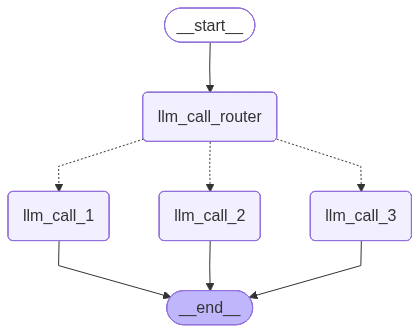

In [3]:
from typing_extensions import Literal,TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage,SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem","joke","story"]= Field(description="The next step in the routing process")

## Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

class State(TypedDict):
    input:str
    decision:str
    output:str

#Node
def llm_call_1(state:State):
    """write a story"""
    result = llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_2(state:State):
    """write a joke"""
    print("llm call 2 is called")
    result = llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_3(state:State):
    """write a story"""
    print("llm call 3 is called")
    result = llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_router(state:State):
    """Route the input to the appropriate node"""
    decision = router.invoke([
        SystemMessage(content="Route the input to story,joke or poem based on the users request"),
        HumanMessage(content=state["input"])
    ])
    return {"decision":decision.step}


    # Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
# Build workflow
router_builder = StateGraph(State)
# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))


In [4]:
state=router_workflow.invoke({"input":"Write me a joke about Agentic AI System"})
print(state["output"])

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': "Here's a joke for you:\n\nWhy did the Agentic AI System get a promotion?  \nBecause it never waited for instructions and always took the initiative... even when the initiative was to schedule its own coffee breaks! ☕🤖"}}